In [1]:
import random 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier as XGBC
import plotly.express as px
from umap import UMAP
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score, roc_curve, roc_auc_score
from plotly.subplots import make_subplots
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

In [2]:
base_path = 'data/cleaned'

X_train = pd.read_csv(f'{base_path}/X_train.csv')
y_train = pd.read_csv(f'{base_path}/y_train.csv')

X_test = pd.read_csv(f'{base_path}/X_test.csv')
y_test = pd.read_csv(f'{base_path}/y_test.csv')

test_df = pd.concat([X_test, y_test],axis=1)

In [3]:
X_train.head()

,admission_age,heart_rate_max,sbp_min,temperature_min,temperature_max,spo2_max,platelets_max,bun_min,chloride_max.1,inr_max,gcs_verbal,weight_admit
0,-1.586491,0.087176,-0.136765,0.422108,-0.040093,0.462535,1.192428,-0.972973,-2.580534,-0.396360,0.280358,-0.752165
1,0.127775,-0.628865,0.207266,-0.009631,1.028408,0.462535,-0.480080,-0.349519,0.374667,-0.025661,-1.172155,0.180866
2,1.369282,-1.249433,-0.423457,-0.343880,-1.039211,0.462535,-0.640214,1.053252,0.210490,2.291209,0.764528,-0.554718
3,-0.136645,-2.156418,0.035251,0.268910,-0.498022,0.462535,-0.577940,0.897388,-0.774578,0.252363,0.764528,0.335726
4,0.928852,-0.056032,-0.136765,-0.427442,-0.803308,-0.347020,-0.026368,-0.453428,1.195557,-0.211011,0.764528,0.827406


In [4]:
test_df.head()

,admission_age,heart_rate_max,sbp_min,temperature_min,temperature_max,spo2_max,platelets_max,bun_min,chloride_max.1,inr_max,gcs_verbal,weight_admit,aki
0,-1.411858,0.803216,-0.136765,0.575305,0.195810,0.462535,-1.823425,-0.557337,0.867201,1.457136,-1.656326,0.893221,1
1,0.119816,-0.724337,1.239359,0.268910,-0.192736,0.462535,-1.067237,-0.661246,-1.267111,-0.396360,0.280358,-0.148211,1
2,1.842898,-0.533393,-2.602320,0.032150,-0.955951,0.462535,0.053699,5.781110,-0.610400,-0.025661,-1.172155,-1.212873,1
3,-0.193893,-1.058489,0.149928,0.881700,0.736999,0.462535,-0.319946,-0.245610,1.031379,-0.489035,-1.656326,-0.051424,1
4,-0.400389,1.376049,1.755406,0.658867,0.348453,-1.156575,-0.996067,-0.609292,0.538845,-0.118336,-0.203813,0.761591,1


In [5]:
y_train.aki.unique()

array([1, 0])

In [6]:
y_train.value_counts()

aki
1      21019
0       9621
Name: count, dtype: int64

In [7]:
y_train.value_counts()[1]

21019

In [8]:
alpha = y_train.value_counts()[0] / len(y_train)

In [9]:
alpha

0.31400130548302874

In [10]:
class_weight_dict = {
    1 : alpha,
    0: 1 - alpha
}

In [12]:
models = {
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=0, class_weight=class_weight_dict),
    'DecisionTreeClassifier': DecisionTreeClassifier(criterion='entropy', random_state=0, class_weight=class_weight_dict),
    'RandomForrest': RandomForestClassifier(criterion='entropy', random_state=0, class_weight=class_weight_dict),
    'SVM': svm.SVC(kernel='rbf', random_state=0, class_weight=class_weight_dict),
    'AdaBoost': AdaBoostClassifier(random_state=0),
    'XGBoost': XGBC(random_state=0, scale_pos_weight=alpha)
}

params = {
    'LogisticRegression': {
        'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10],
        'penalty': ['l2', 'l1']
    },
   'DecisionTreeClassifier': {
        'max_depth': np.arange(start=1, stop=80, step=10)
    },
    'RandomForrest': {
        'n_estimators': np.arange(start=10, stop=100, step=10),
        'max_depth': np.arange(start=1, stop=80, step=10)
    },
    'SVM': {
        'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10]
    },
    'AdaBoost': {
        'n_estimators': np.arange(start=10, stop=50, step=10),
        'learning_rate': np.arange(start=0.1, stop=2.0, step=0.5)
    },
    'XGBoost': {
            'n_estimators': np.arange(start=10, stop=100, step=10),
            'reg_lambda': np.arange(start=0.1, stop=2.0, step=0.5),
            'reg_alpha': [0], # L1 off
            'max_depth': np.arange(start=1, stop=10),
            'learning_rate': np.arange(start=0.1, stop=1.0, step=0.1)
    }
}

In [13]:
records = {}

stratifiedKF = StratifiedKFold(n_splits=5)
for key in models:
    model = models[key]
    grid = params[key]
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=grid,
        scoring='balanced_accuracy',
        n_jobs=-1,
        cv=stratifiedKF,
    )

    grid_search.fit(X_train, y_train.values.ravel())

    pred = grid_search.predict(X_test).astype(int)
    test_df[key] = pred
    records[key] = grid_search
    print(f'{key} cross validation balanced accuracy score = {round(grid_search.best_score_, 4)}')

LogisticRegression cross validation balanced accuracy score = 0.67
DecisionTreeClassifier cross validation balanced accuracy score = 0.6397
RandomForrest cross validation balanced accuracy score = 0.6755
SVM cross validation balanced accuracy score = 0.6787
AdaBoost cross validation balanced accuracy score = 0.6285
XGBoost cross validation balanced accuracy score = 0.6753


In [20]:
balanced_accuracy_test = {key: balanced_accuracy_score(test_df.aki, test_df[key]) for key in models.keys()}

for k, v in balanced_accuracy_test.items():
    print(k, 'Test Balanced Accuracy:', round(v, 4))

LogisticRegression Test Balanced Accuracy: 0.6717
DecisionTreeClassifier Test Balanced Accuracy: 0.6419
RandomForrest Test Balanced Accuracy: 0.676
SVM Test Balanced Accuracy: 0.6845
AdaBoost Test Balanced Accuracy: 0.6269
XGBoost Test Balanced Accuracy: 0.6717


In [21]:
average_test_score = sum([v for _, v in balanced_accuracy_test.items()]) / len(balanced_accuracy_test.items())
print('average test score:', round(average_test_score, 4))

average test score: 0.6621


In [14]:
lr_cm = confusion_matrix(test_df.aki, test_df.LogisticRegression)
dt_cm = confusion_matrix(test_df.aki, test_df.DecisionTreeClassifier)
rf_cm = confusion_matrix(test_df.aki, test_df.RandomForrest)
svm_cm = confusion_matrix(test_df.aki, test_df.SVM)
ada_cm = confusion_matrix(test_df.aki, test_df.AdaBoost)
xgbc_cm = confusion_matrix(test_df.aki, test_df.XGBoost)

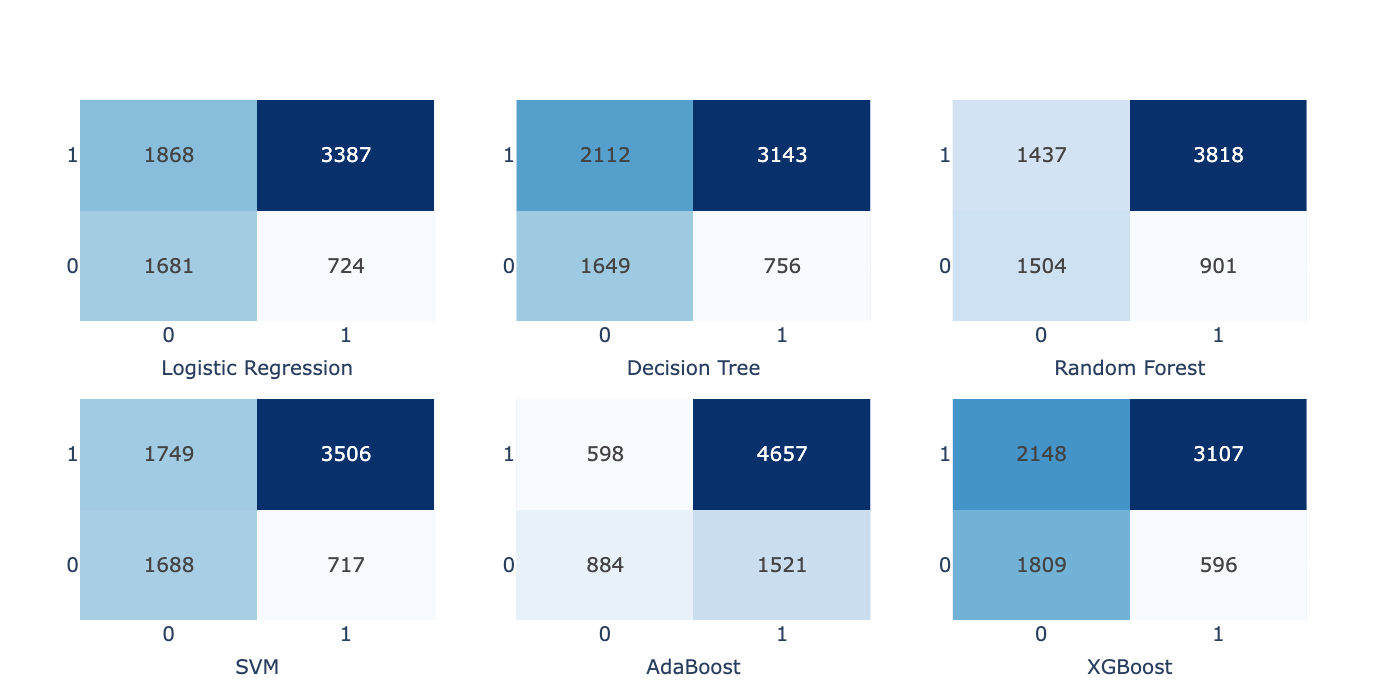

In [29]:
fig = make_subplots(rows=2, cols=3)

fig.add_trace(
    go.Heatmap(
        z=lr_cm, 
        x=['0', '1'], 
        y=['0', '1'], 
        colorscale='Blues',
        text=lr_cm,
        texttemplate="%{text}",
        textfont=dict(size=20),
        showscale=False,
    ),
    row=1, col=1
)

fig.add_trace(
    go.Heatmap(
        z=dt_cm, 
        x=['0', '1'], 
        y=['0', '1'], 
        colorscale='Blues',
        text=dt_cm,
        texttemplate="%{text}",
        textfont=dict(size=20),
        showscale=False,
    ),
    row=1, col=2
)


fig.add_trace(
    go.Heatmap(
        z=rf_cm, 
        x=['0', '1'], 
        y=['0', '1'], 
        colorscale='Blues',
        text=rf_cm,
        texttemplate="%{text}",
        textfont=dict(size=20),
        showscale=False,
    ),
    row=1, col=3
)

fig.add_trace(
    go.Heatmap(
        z=svm_cm, 
        x=['0', '1'], 
        y=['0', '1'], 
        colorscale='Blues',
        text=svm_cm,
        texttemplate="%{text}",
        textfont=dict(size=20),
        showscale=False
    ),
    row=2, col=1
)

fig.add_trace(
    go.Heatmap(
        z=ada_cm, 
        x=['0', '1'], 
        y=['0', '1'], 
        colorscale='Blues',
        text=ada_cm,
        texttemplate="%{text}",
        textfont=dict(size=20),
        showscale=False
    ),
    row=2, col=2
)

fig.add_trace(
    go.Heatmap(
        z=xgbc_cm, 
        x=['0', '1'], 
        y=['0', '1'], 
        colorscale='Blues',
        text=xgbc_cm,
        texttemplate="%{text}",
        textfont=dict(size=20),
        showscale=False
    ),
    row=2, col=3
)

fig.update_xaxes(title_text="Logistic Regression", row=1, col=1)
fig.update_xaxes(title_text="Decision Tree", row=1, col=2)
fig.update_xaxes(title_text="Random Forest", row=1, col=3)
fig.update_xaxes(title_text="SVM", row=2, col=1)
fig.update_xaxes(title_text="AdaBoost", row=2, col=2)
fig.update_xaxes(title_text="XGBoost", row=2, col=3)
for row in range(1, 3):
    for col in range(1, 4):
        fig.update_xaxes(tickfont=dict(size=20), row=row, col=col)
        fig.update_yaxes(tickfont=dict(size=20), row=row, col=col)
        fig.update_xaxes(title_font=dict(size=20), row=row, col=col)

fig.update_layout(
    width=1300, 
    height=700   
)

fig.write_image('data/images/class_weighted_model_cm.png', width=1920, height=1080)
fig.show()

In [16]:
lr_fpr, lr_tpr, _ = roc_curve(test_df.aki, test_df.LogisticRegression)
dt_fpr, dt_tpr, _ = roc_curve(test_df.aki, test_df.DecisionTreeClassifier)
rf_fpr, rf_tpr, _ = roc_curve(test_df.aki, test_df.RandomForrest)
svm_fpr, svm_tpr, _ = roc_curve(test_df.aki, test_df.SVM)
ada_fpr, ada_tpr, _ = roc_curve(test_df.aki, test_df.AdaBoost)
xgbc_fpr, xgbc_tpr, _= roc_curve(test_df.aki, test_df.XGBoost)
auc_lr = roc_auc_score(test_df.aki, test_df.LogisticRegression)
auc_dt = roc_auc_score(test_df.aki, test_df.DecisionTreeClassifier)
auc_rf = roc_auc_score(test_df.aki, test_df.RandomForrest)
auc_svm = roc_auc_score(test_df.aki, test_df.SVM)
auc_ada = roc_auc_score(test_df.aki, test_df.AdaBoost)
auc_xgbc = roc_auc_score(test_df.aki, test_df.XGBoost)

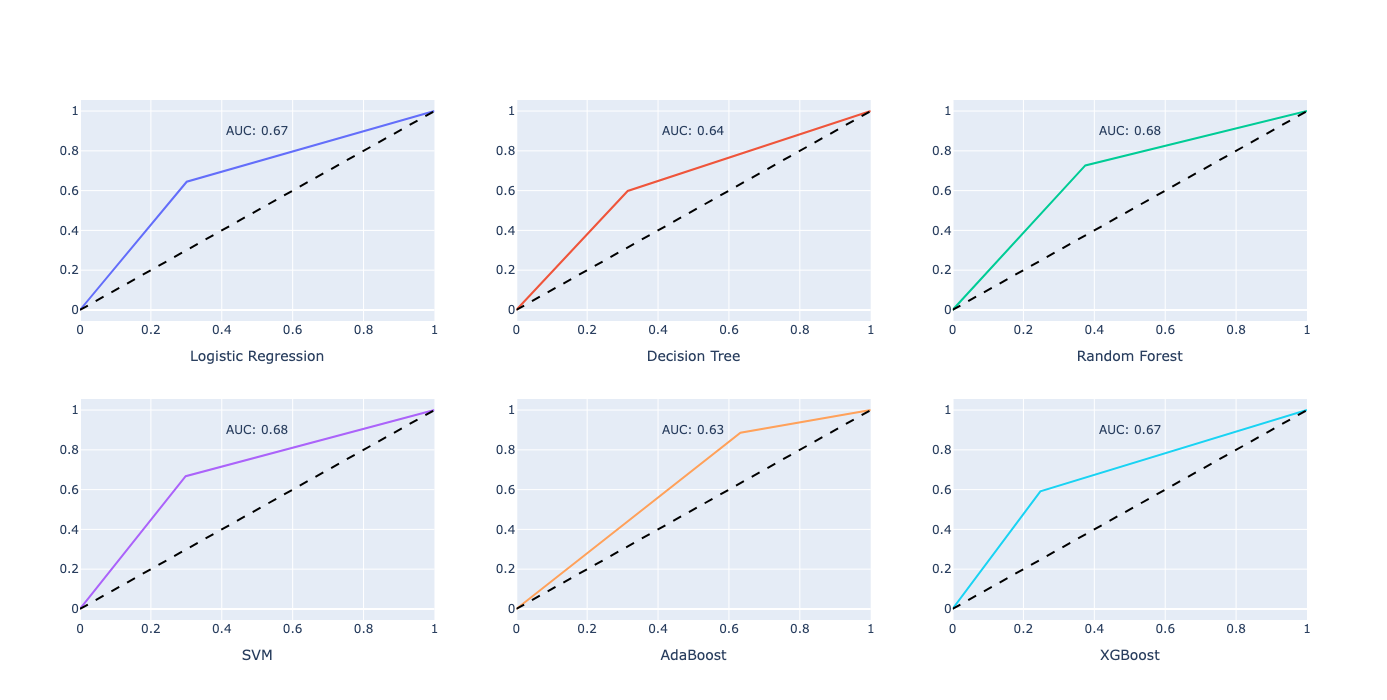

In [23]:
fig = make_subplots(rows=2, cols=3)

fig.add_trace(
    go.Scatter(x=lr_fpr, y=lr_tpr, mode='lines', name='LogisticRegression'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=dt_fpr, y=dt_tpr, mode='lines'),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=rf_fpr, y=rf_tpr, mode='lines'),
    row=1, col=3
)

fig.add_trace(
    go.Scatter(x=svm_fpr, y=svm_tpr, mode='lines'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=ada_fpr, y=ada_tpr, mode='lines'),
    row=2, col=2
)

fig.add_trace(
    go.Scatter(x=xgbc_fpr, y=xgbc_tpr, mode='lines'),
    row=2, col=3
)

random_guess = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line={'dash': 'dash', 'color': 'black'}, name='Random Guess')
for row in range(1, 3):
    for col in range(1, 4):
        fig.add_trace(random_guess, row=row, col=col)

fig.update_xaxes(title_text="Logistic Regression", row=1, col=1)
fig.update_xaxes(title_text="Decision Tree", row=1, col=2)
fig.update_xaxes(title_text="Random Forest", row=1, col=3)
fig.update_xaxes(title_text="SVM", row=2, col=1)
fig.update_xaxes(title_text="AdaBoost", row=2, col=2)
fig.update_xaxes(title_text="XGBoost", row=2, col=3)

fig.add_annotation(text=f'AUC: {auc_lr:.2f}', x=0.5, y=0.9, showarrow=False, row=1, col=1)
fig.add_annotation(text=f'AUC: {auc_dt:.2f}', x=0.5, y=0.9, showarrow=False, row=1, col=2)
fig.add_annotation(text=f'AUC: {auc_rf:.2f}', x=0.5, y=0.9, showarrow=False, row=1, col=3)
fig.add_annotation(text=f'AUC: {auc_svm:.2f}', x=0.5, y=0.9, showarrow=False, row=2, col=1)
fig.add_annotation(text=f'AUC: {auc_ada:.2f}', x=0.5, y=0.9, showarrow=False, row=2, col=2)
fig.add_annotation(text=f'AUC: {auc_xgbc:.2f}', x=0.5, y=0.9, showarrow=False, row=2, col=3)

fig.update_layout(width=1300, height=700, showlegend=False)
fig.write_image('data/images/class_weighted_model_auc.png')
fig.show()